In [1]:
#!pip install nibabel tqdm scikit-image

In [5]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [6]:
#GPU 확인
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3717550024969306415
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [7]:
def preprocess(img_name):
    img_path = path

In [8]:
def img_resize(img) :
    image = resize(image, output_shape=(256, 256, 1), preserve_range=True)
    
    return img

In [9]:
def get_mask_data():

    x_train_path = "dataset/x_train.npy"
    x_val_path = "dataset/x_val.npy" 
    y_train_path = "dataset/y_train.npy"
    y_val_path = "dataset/y_val.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [10]:
def mask_model(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16
    kernel_size = 3
    copy_layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
        net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
        copy_layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        filters = filters*2
    ff2 = 256
  
    #bottleneck 
    j = len(copy_layers) - 1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    filters = filters/2
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = BatchNormalization() (net)
    j = j -1 

    #upsampling 
    for i in range(0, 5):
        net = Conv2D(filters, 3, activation='relu', padding='same') (net)
        net = Conv2D(filters, 3, activation='relu', padding='same') (net)
        print(net.shape)
        filters = filters/2
        net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, copy_layers[j]])
        net = BatchNormalization() (net)
        j = j -1 
    
  
    #classification 
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    net = Conv2D(filters, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(1, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

    model.summary()
    
    
    

    return model

In [11]:
def mask_model2(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16
    kernel_size = 3
    copy_layers = []
    net = inputs
  
    #16
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #32
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #64
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    copy_layers.append(net)
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    #upsampling
    
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]])
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(1, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [12]:
def training_model(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=64, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')

    preds = model.predict(x_val)

    fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
    temp = np.empty((256, 256, 1), dtype=np.float32)

    for i in range(40):
        ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
        ax[i, 0].title.set_text(str(i))
        ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
        ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        temp = x_val[i]
        pred_sum = preds[i][preds[i] > 0]
        pred_mean = np.mean(pred_sum)
        if(np.min(temp) >= 0) :
            temp[preds[i] < pred_mean] = 0
        else :
            temp[preds[i] < pred_mean] = -2048
        ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(1720, 256, 256, 1) (1720, 256, 256, 1)
(192, 256, 256, 1) (192, 256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
________________

Epoch 1/20
27/27 [==============================] - 550s 20s/step - loss: 0.6767 - acc: 0.6935 - mean_io_u: 0.5000 - val_loss: 0.8260 - val_acc: 0.5382 - val_mean_io_u: 0.5000
Epoch 2/20
27/27 [==============================] - 560s 21s/step - loss: 0.5584 - acc: 0.8539 - mean_io_u: 0.5000 - val_loss: 0.6823 - val_acc: 0.5401 - val_mean_io_u: 1.0000
Epoch 3/20
27/27 [==============================] - 578s 21s/step - loss: 0.4778 - acc: 0.8708 - mean_io_u: 0.5000 - val_loss: 0.4511 - val_acc: 0.8665 - val_mean_io_u: 1.0000
Epoch 4/20
27/27 [==============================] - 528s 20s/step - loss: 0.3990 - acc: 0.8748 - mean_io_u: 0.5000 - val_loss: 0.3652 - val_acc: 0.8682 - val_mean_io_u: 1.0000
Epoch 5/20
27/27 [==============================] - 530s 20s/step - loss: 0.3258 - acc: 0.8755 - mean_io_u: 0.5000 - val_loss: 0.2795 - val_acc: 0.8683 - val_mean_io_u: 1.0000
Epoch 6/20
27/27 [==============================] - 525s 19s/step - loss: 0.2610 - acc: 0.8757 - mean_io_u: 1.0000 - val

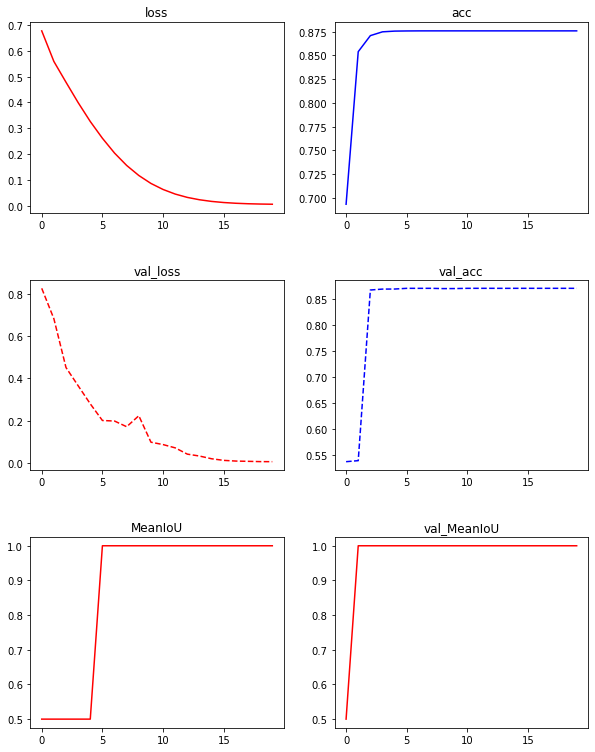

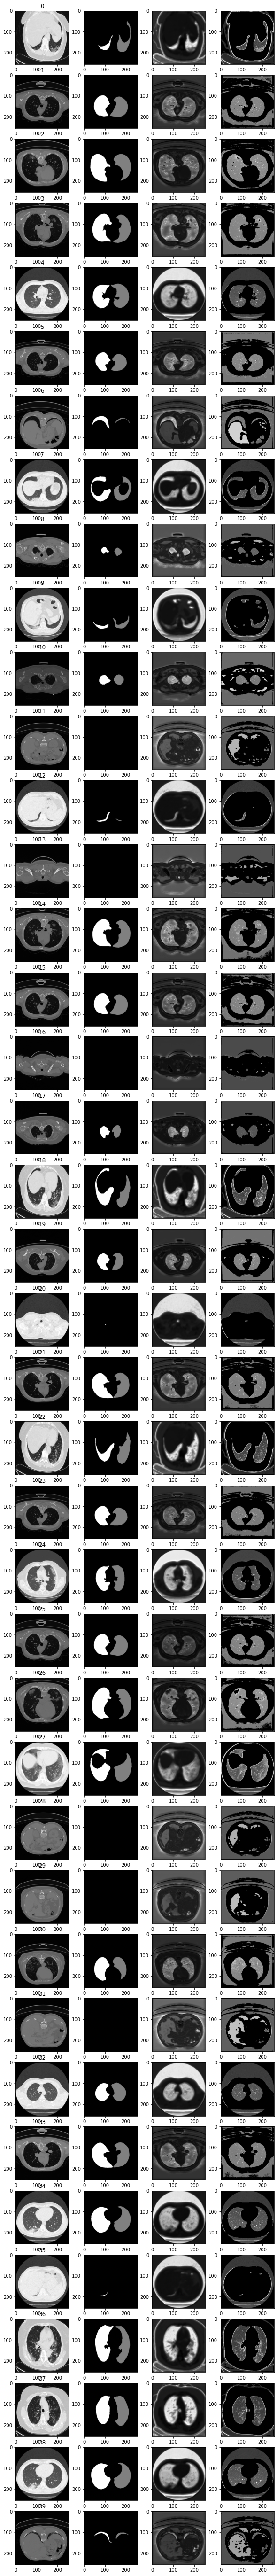

In [13]:
x_train, y_train, x_val, y_val = get_mask_data()
model = mask_model2(x_train, y_train, x_val, y_val)
history = training_model(model,x_train, y_train, x_val, y_val)

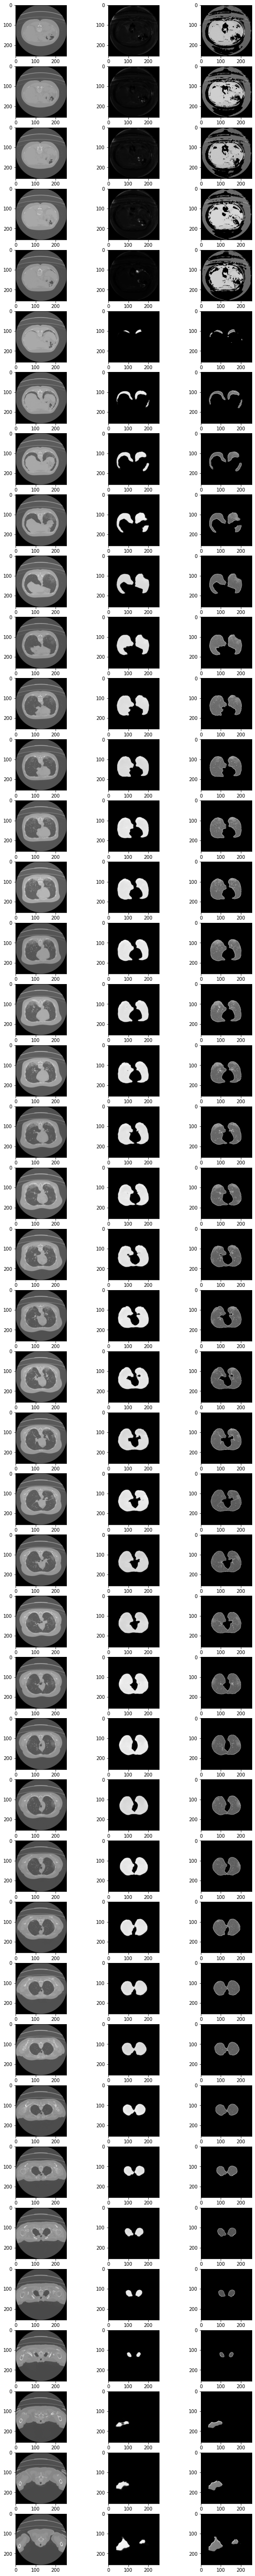

In [11]:
test_name = "study_1110.nii.gz"
test_data = nib.load(test_name)

test_array = np.array(test_data.get_fdata(), dtype=np.float32)
test_array = test_array.T

test = np.empty(( len(test_array),256,256, 1), dtype=np.float32)

for i,img in enumerate(test_array):
    image = resize(img, output_shape=(256, 256, 1), preserve_range=True)
#     img_sum = image[image > -2048]
#     img_mean = np.mean(img_sum)
#     image[image < -1000] = -2048
    test[i] = image



preds=model.predict(test)


fig, ax = plt.subplots(len(preds), 3, figsize=(10, 100))
temp = np.empty((256, 256, 1), dtype=np.float32)

for i, pred in enumerate(preds):
    ax[i,0].imshow(test[i].squeeze(), cmap = "gray")
    ax[i,1].imshow(pred.squeeze(), cmap = "gray")
    temp = test[i]
    pred_sum = pred[pred > 0]
    pred_mean = np.mean(pred_sum)
    if(np.min(temp) >= 0) :
        temp[pred < pred_mean] = 0
    else :
        temp[pred < pred_mean] = -2048
    ax[i, 2].imshow(temp.squeeze(), cmap='gray')
    
